# TODO: DO SHIFTING ON BOTH AXES

In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from sklearn.model_selection import train_test_split
import keras

from wavhandler import *
from utils import *

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)
import seaborn as sns
sns.set()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
Using TensorFlow backend.


In [2]:
import librosa
from scipy import signal
import math
seed = 2018
np.random.seed(seed)
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.layers import Input

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger

from keras import Model
from keras import backend as K

from keras.utils import np_utils
from keras.preprocessing import image

from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception

In [3]:
# current_model = DenseNet121
# current_model = DenseNet169
# current_model = DenseNet201
# current_model = InceptionResNetV2
# current_model = InceptionV3
# current_model = MobileNet
# current_model = NASNetLarge
# current_model = NASNetMobile
current_model = VGG16
# current_model = VGG19
# current_model = Xception

model_name = TEMP_DATADIR + 'wingbeats_' + current_model.__name__

best_weights_path = model_name + '.h5'
log_path = model_name + '.log'
monitor = 'val_acc'
batch_size = 32
epochs = 100
es_patience = 7
rlr_patience = 3

SR = 8000
N_FFT = 256
HOP_LEN = int(N_FFT / 6)
input_shape = (129, 120, 1)

In [4]:
# DATADIR = '/home/kalfasyan/data/insects/increasing dataset/'
# DATADIR = '/home/kalfasyan/data/insects/LG2/'
# 

target_names = mosquitos_6#os.listdir(DATADIR)

filenames, y = get_data(#filedir= DATADIR,
                      target_names=target_names, nr_signals=np.inf, only_names=True)
print(target_names)

X_names, y = shuffle(filenames, y, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X_names, y, stratify = y, test_size = 0.20, random_state = seed)

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']


In [5]:
def train_generator():
    while True:
        for start in range(0, len(X_train), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(X_train))
            train_batch = X_train[start:end]
            labels_batch = y_train[start:end]

            for i in range(len(train_batch)):
                data, rate = librosa.load(train_batch[i], sr = SR)

                #data = random_data_shift(data, u = 1.0)

                data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
                data = librosa.amplitude_to_db(np.abs(data))
                data = np.flipud(data)

                data = np.expand_dims(data, axis = -1)
                data = random_data_shift(data, w_limit = (-0.25, 0.25), h_limit = (-0.0, 0.0), cval = np.min(data), u = 1.0)

                # data = np.squeeze(data, axis = -1)
                # plt.imshow(data, cmap = 'gray')
                # plt.show()
                # data = np.expand_dims(data, axis = -1)

                x_batch.append(data)
                y_batch.append(labels_batch[i])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)

            y_batch = np_utils.to_categorical(y_batch, len(target_names))

            yield x_batch, y_batch

In [6]:
int(round(np.random.uniform(-(len(data)), (len(data)))))

NameError: name 'data' is not defined

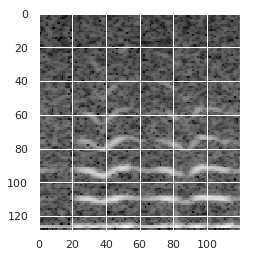

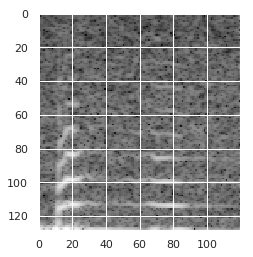

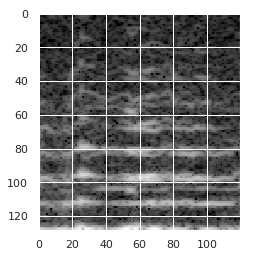

In [65]:
def random_data_shift_simple(data, u, shift_pct=0.006, axis=0):
    if np.random.random() < u:
        data = np.roll(data, int(round(np.random.uniform(-(len(data)*shift_pct), (len(data)*shift_pct)))), axis=axis)
    return data

for start in range(0, len(X_train), batch_size):
    x_batch = []
    y_batch = []

    end = min(start + batch_size, len(X_train))
    train_batch = X_train[start:end]
    labels_batch = y_train[start:end]

    for i in range(len(train_batch)):
        data, rate = librosa.load(train_batch[i], sr = SR)

        #data = random_data_shift(data, u = 1.0)

        data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
        data = librosa.amplitude_to_db(np.abs(data))
        data = np.flipud(data)
#         data = np.random.randint(0,,size=data.shape)

        data = np.expand_dims(data, axis = -1)
        data = random_data_shift_simple(data, u=0.5, shift_pct=0.006, axis=0)
        data = random_data_shift_simple(data, u=0.5, shift_pct=0.45, axis=1)

        data = np.squeeze(data, axis = -1)
        plt.imshow(data, cmap = 'gray')
        plt.show()
        data = np.expand_dims(data, axis = -1)
        if i > 1 :
            break
    break

In [24]:
data.shape

(129, 120, 1)

In [111]:
data.shape[1]

120

In [7]:
def valid_generator():
    while True:
        for start in range(0, len(X_test), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(X_test))
            test_batch = X_test[start:end]
            labels_batch = y_test[start:end]

            for i in range(len(test_batch)):
                data, rate = librosa.load(test_batch[i], sr = SR)

                data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
                data = librosa.amplitude_to_db(np.abs(data))
                data = np.flipud(data)

                data = np.expand_dims(data, axis = -1)

                x_batch.append(data)
                y_batch.append(labels_batch[i])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)

            y_batch = np_utils.to_categorical(y_batch, len(target_names))

            yield x_batch, y_batch

In [8]:
# for start in range(0, len(X_test), batch_size):
#     x_batch = []
#     y_batch = []

#     end = min(start + batch_size, len(X_test))
#     test_batch = X_test[start:end]
#     labels_batch = y_test[start:end]

#     for i in range(len(test_batch)):
#         data, rate = librosa.load(test_batch[i], sr = SR)

#         data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
# #                 data = librosa.amplitude_to_db(data)
#         data = np.abs(data)
#         data = np.flipud(data)

#         data = np.expand_dims(data, axis = -1)

#         x_batch.append(data)
#         y_batch.append(labels_batch[i])

#     x_batch = np.array(x_batch, np.float32)
#     y_batch = np.array(y_batch, np.float32)

#     y_batch = np_utils.to_categorical(y_batch, len(target_names))
#     break

In [9]:
# plt.figure(figsize=(14,14))
# plt.imshow(x_batch[0].squeeze())
# plt.colorbar()
# plt.grid(False)
# plt.title(str(x_batch[0].shape))
# data.shape

In [10]:
img_input = Input(shape = input_shape)

model = current_model(input_tensor = img_input, classes = len(target_names), weights = None)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks_list = [ModelCheckpoint(monitor = monitor,
                                filepath = best_weights_path,
                                save_best_only = True,
                                save_weights_only = True,
                                verbose = 1),
                    EarlyStopping(monitor = monitor,
                                patience = es_patience,
                                verbose = 1),
                    ReduceLROnPlateau(monitor = monitor,
                                factor = 0.1,
                                patience = rlr_patience,
                                verbose = 1),
                    CSVLogger(filename = log_path)]

In [ ]:
model.fit_generator(train_generator(),
    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(batch_size))),
    validation_data = valid_generator(),
    validation_steps = int(math.ceil(float(len(X_test)) / float(batch_size))),
    epochs = epochs,
    callbacks = callbacks_list,
    shuffle = False)

In [ ]:
model.load_weights(best_weights_path)

loss, acc = model.evaluate_generator(valid_generator(),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

#print('loss:', loss)
print('Test accuracy:', acc)